--- Iniciando Simulación de Maestranza ---
[6.05] *** Nueva ORDEN recibida. Tamaño del lote: 2 poleas ***
[6.05] Día 6: Llega Orden de Polea 1
[6.05] Día 6: Llega Orden de Polea 2
[6.05] *** Nueva ORDEN recibida. Tamaño del lote: 1 poleas ***
[6.05] Día 6: Llega Orden de Polea 3
[8.53] *** Nueva ORDEN recibida. Tamaño del lote: 2 poleas ***
[8.53] Día 8: Llega Orden de Polea 4
[8.53] Día 8: Llega Orden de Polea 5
[8.88] *** Nueva ORDEN recibida. Tamaño del lote: 2 poleas ***
[8.88] Día 8: Llega Orden de Polea 6
[8.88] Día 8: Llega Orden de Polea 7
[9.27] Polea 3: Manto y Tapas listos. Inicia Ensamblaje Intermedio.
[9.33] Polea 2: Manto y Tapas listos. Inicia Ensamblaje Intermedio.
[9.39] Polea 1: Manto y Tapas listos. Inicia Ensamblaje Intermedio.
[9.63] Polea 3: Ensamblaje listo. Pasa a Vulcanizado.
[9.63] Polea 3: Esperando por 1 Op. Vulcanizado y 1 Autoclave
[9.63] Polea 3: Inicia Vulcanizado (con 1 op.)
[9.67] Polea 2: Ensamblaje listo. Pasa a Vulcanizado.
[9.67] Polea 2: Esperando

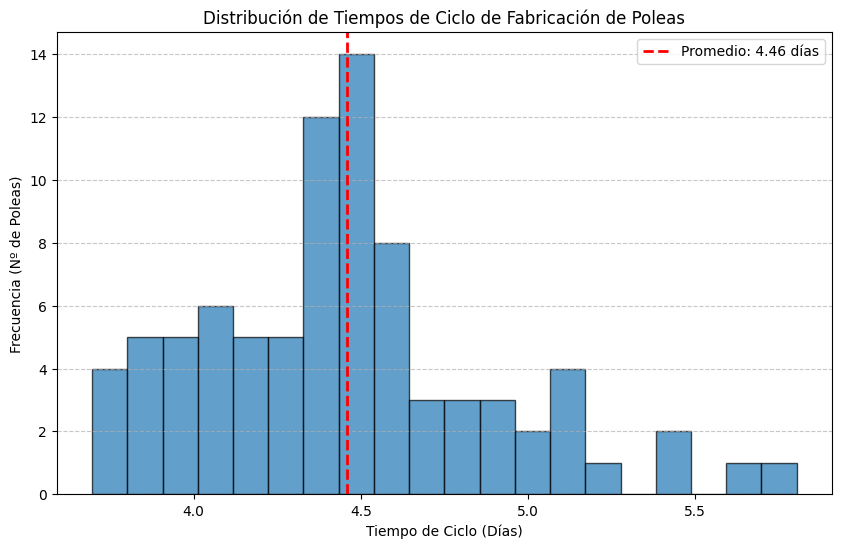

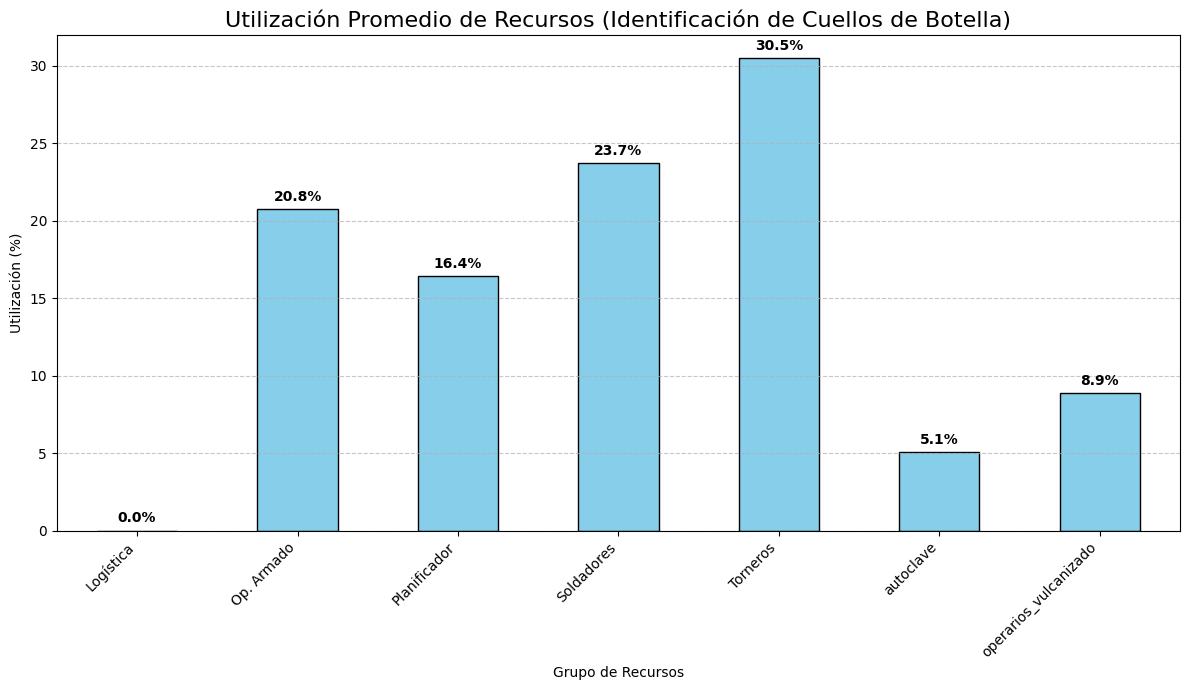

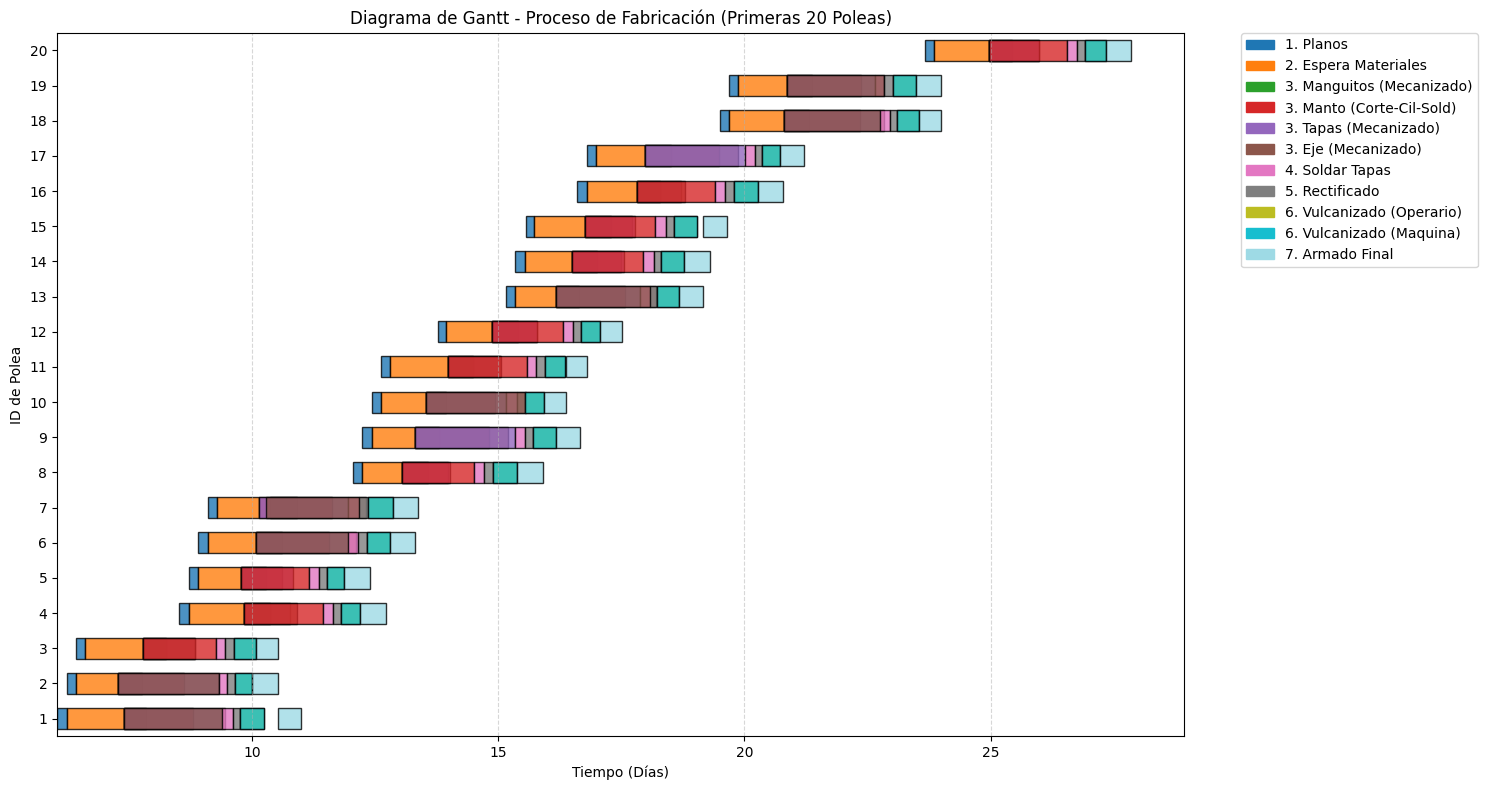

In [6]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Constantes de Tiempo ---
HORAS = 1/24.0  # Fracción de un día
MINUTOS = 1/(24.0 * 60.0) # Fracción de un día (para 1 minuto)
DIAS_SIMULACION = 100 # Simular por 100 días
TIEMPO_LLEGADA_PROMEDIO = 2.33 # Promedio de días ENTRE ÓRDENES

# --- Lista para registrar eventos (para Gantt) ---
eventos = []
# --- Lista para registrar resultados (para histograma) ---
datos_resumen = []

def registrar_evento(id_polea, tarea, recurso, inicio, fin):
    """Registra un evento para el diagrama de Gantt."""
    eventos.append({
        "ID_Polea": id_polea,
        "Tarea": tarea,
        "Recurso": recurso,
        "Inicio": inicio,
        "Fin": fin
    })

# --- 1. Definición de Recursos (Pools) ---
def crear_recursos(env):
    """Crea los pools de recursos basados en la entrevista."""
    return {
        # 1 persona para planos/gestión
        "planificador": simpy.Resource(env, capacity=1),
        
        # ~6 personas para corte, cilindrado, soldadura
        "soldadores": simpy.Resource(env, capacity=6),
        
        # ~10 personas para tornos (tapas, ejes, manguitos, rectificado)
        "torneros": simpy.Resource(env, capacity=10),
        
        # === CAMBIO CLAVE AQUÍ ===
        # 4 operarios en el área de vulcanizado
        "operarios_vulcanizado": simpy.Resource(env, capacity=4),
        
        # 1 máquina autoclave con capacidad promedio para 7 poleas
        "autoclave": simpy.Resource(env, capacity=7),
        # === FIN DEL CAMBIO ===
        
        # ~2 personas para armado final
        "operarios_armado": simpy.Resource(env, capacity=2)
    }

# --- 2. Sub-procesos (Tareas individuales) ---

def fase_inicial(env, id_polea, recursos):
    """Desarrollo de planos y espera de materiales."""
    # 2.1. Desarrollo de Planos (usa 1 planificador)
    with recursos["planificador"].request() as req:
        yield req
        inicio = env.now
        # 4 a 5 horas. (Usamos 4, 4.5, y 5 horas)
        t_planos = random.triangular(4*HORAS, 4.5*HORAS, 5*HORAS)
        yield env.timeout(t_planos)
    registrar_evento(id_polea, "1. Planos", "Planificador", inicio, env.now)
    
    # 2.2. Espera de Materiales (no usa recurso, solo es tiempo)
    inicio_mat = env.now
    t_materiales = random.uniform(0.8, 1.2) # min, max (días)
    yield env.timeout(t_materiales)
    registrar_evento(id_polea, "2. Espera Materiales", "Logística", inicio_mat, env.now)

def proceso_manto(env, id_polea, recursos):
    """Corte, cilindrado y soldadura longitudinal. Usa 1 soldador."""
    with recursos["soldadores"].request() as req:
        yield req
        inicio = env.now # Iniciar cronómetro DESPUÉS de tomar el recurso
        # 2.3. Corte Láser (ahora usa MINUTOS)
        t_corte = random.uniform(10*MINUTOS, 25*MINUTOS)
        yield env.timeout(t_corte)
        # 2.4. Cilindrado
        yield env.timeout(random.triangular(0.4, 0.5, 0.6))      
        # 2.5. Soldadura Longitudinal
        yield env.timeout(random.triangular(0.8, 1.0, 1.2))

    registrar_evento(id_polea, "3. Manto (Corte-Cil-Sold)", "Soldadores", inicio, env.now)
    
def proceso_tapas(env, id_polea, recursos, tipo_polea):
    """Mecanizado de tapas. Usa 1 tornero."""
    with recursos["torneros"].request() as req:
        yield req
        inicio = env.now # Iniciar cronómetro DESPUÉS de tomar el recurso
        if tipo_polea == 'grande':
            t_tapas = random.triangular(1.5, 2.0, 2.2)
        else:
            t_tapas = random.triangular(0.8, 1.0, 1.2)
        yield env.timeout(t_tapas)
    registrar_evento(id_polea, "3. Tapas (Mecanizado)", "Torneros", inicio, env.now)

def proceso_eje(env, id_polea, recursos, tipo_polea):
    """Fabricación de eje (depende del tamaño). Usa 1 tornero."""
    with recursos["torneros"].request() as req:
        yield req
        inicio = env.now # Iniciar cronómetro DESPUÉS de tomar el recurso
        if tipo_polea == 'grande':
            # 2 días (día y noche)
            t_eje = random.triangular(1.8, 2.0, 2.2)
        else:
            # 1 día (polea chica)
            t_eje = random.triangular(0.8, 1.0, 1.2)         
        yield env.timeout(t_eje)
    registrar_evento(id_polea, "3. Eje (Mecanizado)", "Torneros", inicio, env.now)

def proceso_manguitos(env, id_polea, recursos):
    """Fabricación de manguitos. Usa 1 tornero."""
    with recursos["torneros"].request() as req:
        yield req
        inicio = env.now # Iniciar cronómetro DESPUÉS de tomar el recurso
        yield env.timeout(random.triangular(0.4, 0.5, 0.6))
    registrar_evento(id_polea, "3. Manguitos (Mecanizado)", "Torneros", inicio, env.now)
    
def ensamblaje_intermedio(env, id_polea, recursos):
    """Soldar tapas y rectificar. Usa 1 soldador, luego 1 tornero."""
    # 4.1. Soldar Tapas al Manto (usa 1 soldador)
    with recursos["soldadores"].request() as req:
        yield req
        inicio = env.now # Iniciar cronómetro DESPUÉS de tomar el recurso
        yield env.timeout(random.triangular(4*HORAS, 5*HORAS, 6*HORAS))
    registrar_evento(id_polea, "4. Soldar Tapas", "Soldadores", inicio, env.now)
    # 4.2. Rectificado Exterior (usa 1 tornero)
    with recursos["torneros"].request() as req:
        yield req
        inicio_rect = env.now # Iniciar cronómetro DESPUÉS de tomar el recurso
        yield env.timeout(random.triangular(3*HORAS, 4*HORAS, 5*HORAS))
    registrar_evento(id_polea, "5. Rectificado", "Torneros", inicio_rect, env.now)

def vulcanizado(env, id_polea, recursos):
    """Proceso completo de vulcanizado. Usa 1 operario y 1 slot de autoclave."""
    print(f"[{env.now:.2f}] Polea {id_polea}: Esperando por 1 Op. Vulcanizado y 1 Autoclave")
    with recursos["operarios_vulcanizado"].request() as req_op:
        yield req_op 
        with recursos["autoclave"].request() as req_aut:
            yield req_aut    
            inicio_proceso = env.now # Iniciar cronómetro DESPUÉS de tomar AMBOS recursos
            print(f"[{env.now:.2f}] Polea {id_polea}: Inicia Vulcanizado (con 1 op.)")
            
            t_vulcanizado = random.uniform(8*HORAS, 12*HORAS)
            yield env.timeout(t_vulcanizado) 
            fin_proceso = env.now # Registrar fin    
    # Registrar el tiempo de PROCESO real para cada recurso
    registrar_evento(id_polea, "6. Vulcanizado (Operario)", "operarios_vulcanizado", inicio_proceso, fin_proceso)
    registrar_evento(id_polea, "6. Vulcanizado (Maquina)", "autoclave", inicio_proceso, fin_proceso)
    print(f"[{env.now:.2f}] Polea {id_polea}: Termina Vulcanizado")

def armado_final(env, id_polea, recursos):
    """Ensamblaje final (Eje, Manguitos, Rodamientos). Usa 2 operarios."""
    with recursos["operarios_armado"].request() as req:
        yield req
        inicio = env.now # Iniciar cronómetro DESPUÉS de tomar el recurso
        yield env.timeout(random.triangular(0.4, 0.5, 0.6))
    registrar_evento(id_polea, "7. Armado Final", "Op. Armado", inicio, env.now)

# --- 3. Proceso Principal (Orquestador por Polea) ---

def polea_proceso(env, id_polea, recursos, datos_resumen):
    """Orquesta la fabricación completa de una polea."""
    print(f"[{env.now:.2f}] Día {int(env.now)}: Llega Orden de Polea {id_polea}")
    t_inicio_ciclo = env.now
    
    # Decide aleatoriamente el tipo de polea
    tipo_polea = random.choice(['chica', 'grande'])
    
    # 1. Fase Inicial (Secuencial)
    yield env.process(fase_inicial(env, id_polea, recursos))
    
    # 2. Fabricación Paralela de Componentes
    p_manto = env.process(proceso_manto(env, id_polea, recursos))
    p_tapas = env.process(proceso_tapas(env, id_polea, recursos, tipo_polea))
    p_eje = env.process(proceso_eje(env, id_polea, recursos, tipo_polea))
    p_manguitos = env.process(proceso_manguitos(env, id_polea, recursos))
    
    # 3. Sincronización 1: Ensamblaje Intermedio
    yield p_manto & p_tapas
    print(f"[{env.now:.2f}] Polea {id_polea}: Manto y Tapas listos. Inicia Ensamblaje Intermedio.")
    p_ensamblada = env.process(ensamblaje_intermedio(env, id_polea, recursos))
    
    # 4. Sincronización 2: Vulcanizado
    yield p_ensamblada
    print(f"[{env.now:.2f}] Polea {id_polea}: Ensamblaje listo. Pasa a Vulcanizado.")
    p_vulcanizada = env.process(vulcanizado(env, id_polea, recursos))
    
    # 5. Sincronización 3: Armado Final
    yield p_vulcanizada & p_eje & p_manguitos
    print(f"[{env.now:.2f}] Polea {id_polea}: Vulcanizada, Eje y Manguitos listos. Inicia Armado Final.")
    
    # 6. Fase Final
    yield env.process(armado_final(env, id_polea, recursos))
    
    # 7. Fin
    t_fin_ciclo = env.now
    t_total_ciclo = t_fin_ciclo - t_inicio_ciclo
    print(f"[{env.now:.2f}] Polea {id_polea} TERMINADA. Tiempo total: {t_total_ciclo:.2f} días.")
    
    # Guardar resultados
    datos_resumen.append({
        "id_polea": id_polea,
        "tipo": tipo_polea,
        "tiempo_ciclo": t_total_ciclo
    })

# --- 4. Generador de Llegadas ---

def llegada_ordenes(env, recursos, datos_resumen, id_counter):
    """Genera llegadas de nuevas ÓRDENES (lotes) de poleas."""
    
    while True:
        # 1. Espera un tiempo aleatorio para la próxima ORDEN
        t_llegada = random.expovariate(1.0 / TIEMPO_LLEGADA_PROMEDIO)
        yield env.timeout(t_llegada)

        tamano_lote = int(random.triangular(1, 2, 5))
        print(f"[{env.now:.2f}] *** Nueva ORDEN recibida. Tamaño del lote: {tamano_lote} poleas ***")

        # 3. Crea todas las poleas de ese lote al mismo tiempo
        for i in range(tamano_lote):
            id_counter[0] += 1
            env.process(polea_proceso(env, id_counter[0], recursos, datos_resumen))

# --- 5. Ejecución y Análisis ---

print("--- Iniciando Simulación de Maestranza ---")
# Creamos el entorno y los recursos ANTES de pasarlos
env = simpy.Environment()
recursos = crear_recursos(env)
id_counter = [0] # Creamos un contador
env.process(llegada_ordenes(env, recursos, datos_resumen, id_counter))
env.run(until=DIAS_SIMULACION)
print(f"--- Simulación terminada a los {DIAS_SIMULACION} días ---")

# --- 5.1. Preparación de DataFrames ---
df_resumen = pd.DataFrame(datos_resumen)
df_eventos = pd.DataFrame(eventos)

# Guardar archivos .csv (o .doe)
df_eventos.to_csv("simulacion_eventos_gantt.doe", index=False) # Guardamos como .doe
df_resumen.to_csv("simulacion_resumen_estadistico.csv", index=False)
print(f"\nArchivos 'simulacion_eventos_gantt.doe' y 'simulacion_resumen_estadistico.csv' generados")

# --- 5.2. Análisis Estadístico Básico ---
print("\n--- Resumen Estadístico de Tiempos de Ciclo (en días) ---")
print(df_resumen['tiempo_ciclo'].describe())

# --- 5.3. Gráfico 1: Histograma de Tiempos de Ciclo (Este ya lo tenías) ---
plt.figure(figsize=(10, 6))
plt.hist(df_resumen['tiempo_ciclo'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribución de Tiempos de Ciclo de Fabricación de Poleas')
plt.xlabel('Tiempo de Ciclo (Días)')
plt.ylabel('Frecuencia (Nº de Poleas)')
plt.axvline(df_resumen['tiempo_ciclo'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Promedio: {df_resumen['tiempo_ciclo'].mean():.2f} días")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("1_histograma_tiempos_ciclo.png")
print("Gráfico '1_histograma_tiempos_ciclo.png' generado")

# GRÁFICO 1: UTILIZACIÓN DE RECURSOS
print("Generando gráfico de utilización...")

# 1. Calcular duración de cada evento
df_eventos['Duracion'] = df_eventos['Fin'] - df_eventos['Inicio']

# 2. Agrupar por recurso y sumar el tiempo total que estuvieron ocupados
tiempo_ocupado = df_eventos.groupby('Recurso')['Duracion'].sum()

# 3. Crear un diccionario con la capacidad de cada recurso (del setup inicial)
#    Es importante que los strings coincidan con los del setup de recursos

capacidades = {
    "Planificador": 1,
    "Soldadores": 6,
    "Torneros": 10,
    "Op. Armado": 2,
    "operarios_vulcanizado": 4,
    "autoclave": 7
}
# Convertir a Series de pandas
s_capacidades = pd.Series(capacidades, name="Capacidad")

# 4. Combinar los datos de tiempo ocupado y capacidad
df_utilizacion = pd.DataFrame(tiempo_ocupado)
df_utilizacion = df_utilizacion.join(s_capacidades)

# 5. Calcular tiempo total disponible y utilización
df_utilizacion['Tiempo_Disponible'] = df_utilizacion['Capacidad'] * DIAS_SIMULACION
df_utilizacion['Utilizacion_%'] = (df_utilizacion['Duracion'] / df_utilizacion['Tiempo_Disponible']) * 100

# 6. Graficar
plt.figure(figsize=(12, 7))
ax = df_utilizacion['Utilizacion_%'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Utilización Promedio de Recursos (Identificación de Cuellos de Botella)', fontsize=16)
plt.ylabel('Utilización (%)')
plt.xlabel('Grupo de Recursos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de porcentaje sobre las barras
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

plt.tight_layout()
plt.savefig("2_grafico_utilizacion_recursos.png")
print("Gráfico '2_grafico_utilizacion_recursos.png' generado")



# --- Gráfico de Gantt---
df_gantt = df_eventos[df_eventos['ID_Polea'] <= 20]
if not df_gantt.empty:
    fig, ax = plt.subplots(figsize=(15, 8))
    
    tareas_unicas = df_gantt['Tarea'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(tareas_unicas)))
    color_map = dict(zip(tareas_unicas, colors))

    ax.set_yticks(df_gantt['ID_Polea'].unique())
    ax.set_ylim(0.5, 20.5) 

    for _, row in df_gantt.iterrows():
        ax.barh(
            y=row['ID_Polea'], 
            width=row['Fin'] - row['Inicio'], 
            left=row['Inicio'], 
            height=0.6,
            color=color_map[row['Tarea']],
            edgecolor='black',
            alpha=0.8
        )

    patches = [plt.Rectangle((0,0),1,1, color=color_map[tarea], label=tarea) for tarea in tareas_unicas]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax.set_xlabel("Tiempo (Días)")
    ax.set_ylabel("ID de Polea")
    ax.set_title("Diagrama de Gantt - Proceso de Fabricación (Primeras 20 Poleas)")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.savefig("4_diagrama_gantt_poleas.png")
    print("Gráfico '4_diagrama_gantt_poleas.png' generado")
else:
    print("No se generaron eventos suficientes para el Gantt.")

print("\n--- ¡Análisis completo! Revisa los archivos .png generados. ---")
